# 基于Transformers的命名实体识别

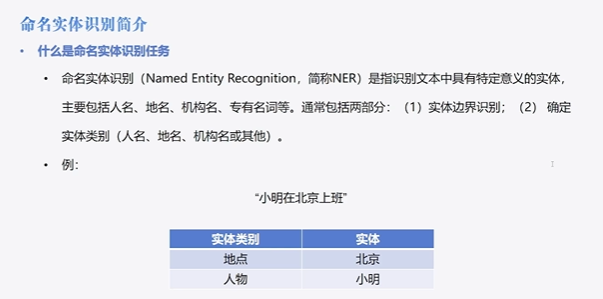

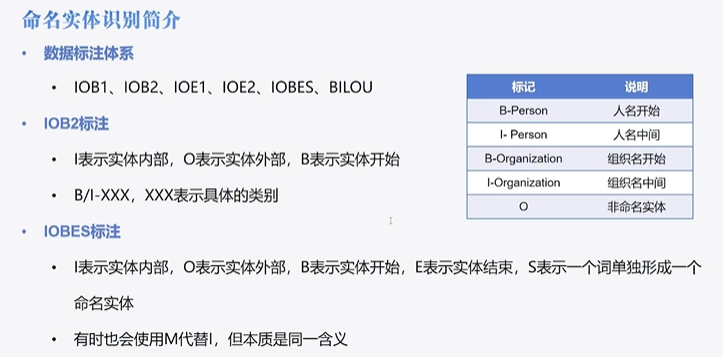

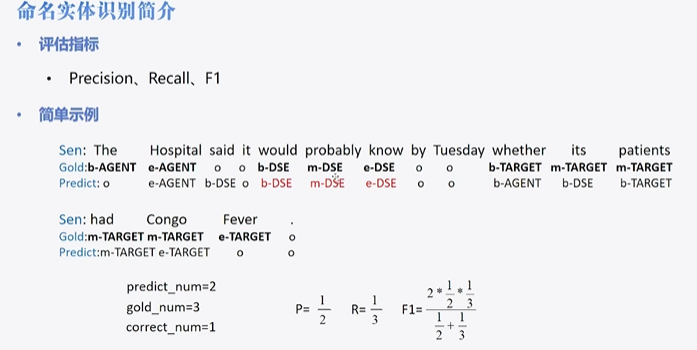

维度：

1. 命名体识别(一个token一个类别）：输出的logits维度应该是[batch * sequence_length * num_labels]

2. 文本分类（一句话一个类别）：输出的logits [batch * num_labels]

## Step1 导入相关包

In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0,1,2,3'

import evaluate
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForTokenClassification, TrainingArguments, Trainer, DataCollatorForTokenClassification

/data1/zhengnanyan/miniconda3/envs/LLMpython39/lib/python3.9/site-packages/transformers/utils/hub.py:124: FutureWarning: Using `TRANSFORMERS_CACHE` is deprecated and will be removed in v5 of Transformers. Use `HF_HOME` instead.
  warnings.warn(


## Step2 加载数据集

In [2]:
# 如果可以联网，直接使用load_dataset进行加载
#ner_datasets = load_dataset("peoples_daily_ner", cache_dir="./data")
# 如果无法联网，则使用下面的方式加载数据集
from datasets import DatasetDict
ner_datasets = DatasetDict.load_from_disk("ner_data")
ner_datasets

DatasetDict({
    train: Dataset({
        features: ['id', 'tokens', 'ner_tags'],
        num_rows: 20865
    })
    validation: Dataset({
        features: ['id', 'tokens', 'ner_tags'],
        num_rows: 2319
    })
    test: Dataset({
        features: ['id', 'tokens', 'ner_tags'],
        num_rows: 4637
    })
})

In [3]:
ner_datasets['train']

Dataset({
    features: ['id', 'tokens', 'ner_tags'],
    num_rows: 20865
})

In [4]:
ner_datasets["train"][0]

{'id': '0',
 'tokens': ['海',
  '钓',
  '比',
  '赛',
  '地',
  '点',
  '在',
  '厦',
  '门',
  '与',
  '金',
  '门',
  '之',
  '间',
  '的',
  '海',
  '域',
  '。'],
 'ner_tags': [0, 0, 0, 0, 0, 0, 0, 5, 6, 0, 5, 6, 0, 0, 0, 0, 0, 0]}

In [5]:
ner_datasets["train"].features

{'id': Value(dtype='string', id=None),
 'tokens': Sequence(feature=Value(dtype='string', id=None), length=-1, id=None),
 'ner_tags': Sequence(feature=ClassLabel(names=['O', 'B-PER', 'I-PER', 'B-ORG', 'I-ORG', 'B-LOC', 'I-LOC'], id=None), length=-1, id=None)}

In [3]:
# 获取ner数据集的label
label_list = ner_datasets["train"].features["ner_tags"].feature.names
label_list

['O', 'B-PER', 'I-PER', 'B-ORG', 'I-ORG', 'B-LOC', 'I-LOC']

## Step3 数据集预处理

In [4]:
tokenizer = AutoTokenizer.from_pretrained("hfl/chinese-macbert-base")

In [5]:
tokenizer(ner_datasets["train"][0]["tokens"])
# 这时候token把ner_datasets["train"][0]里的tokens ['海',
#   '钓',
#   '比',……]
# 都当成句子，所以加上了cls和sep，但实际上tokens列表里已经是词了

{'input_ids': [[101, 3862, 102], [101, 7157, 102], [101, 3683, 102], [101, 6612, 102], [101, 1765, 102], [101, 4157, 102], [101, 1762, 102], [101, 1336, 102], [101, 7305, 102], [101, 680, 102], [101, 7032, 102], [101, 7305, 102], [101, 722, 102], [101, 7313, 102], [101, 4638, 102], [101, 3862, 102], [101, 1818, 102], [101, 511, 102]], 'token_type_ids': [[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0]], 'attention_mask': [[1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1]]}

In [11]:
# 加上is_split_into_words=True，就会把整个tokens列表当成一个句子
# 在整个tokens最前面和最后面加上cls和sep
tokenizer(ner_datasets["train"][0]["tokens"], is_split_into_words=True)   # 对于已经做好tokenize的数据，要指定is_split_into_words参数为True

{'input_ids': [101, 3862, 7157, 3683, 6612, 1765, 4157, 1762, 1336, 7305, 680, 7032, 7305, 722, 7313, 4638, 3862, 1818, 511, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

我们在上面对训练集做了tokenizer，这时候要把标签也一一对应上，但是原始训练集的ner_tags现在已经不能和上面的输出一一对应了。

因为会有子词。

解释如下：

In [12]:
res = tokenizer("interesting word")
# 两个词被拆成5个token，哪些token是哪个词呢
res

{'input_ids': [101, 10673, 12865, 12921, 8181, 8681, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1]}

word_ids()：哪几个token属于哪个词

In [9]:
res.word_ids()
# word_ids()：哪几个token属于哪个词

[None, 0, 0, 0, 0, 1, None]

In [6]:
# 借助word_ids 实现标签映射
def process_function(examples):
    tokenized_exmaples = tokenizer(examples["tokens"], max_length=128, truncation=True, is_split_into_words=True)
    labels = []
    for i, label in enumerate(examples["ner_tags"]):
        word_ids = tokenized_exmaples.word_ids(batch_index=i)
        label_ids = []
        for word_id in word_ids:
            if word_id is None:  # cls和sep
                label_ids.append(-100)  # -100交叉熵函数计算默认忽略的值 
            else:
                label_ids.append(label[word_id])
        labels.append(label_ids)
    tokenized_exmaples["labels"] = labels
    return tokenized_exmaples

In [7]:
tokenized_datasets = ner_datasets.map(process_function, batched=True)
tokenized_datasets

Map:   0%|          | 0/4637 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['id', 'tokens', 'ner_tags', 'input_ids', 'token_type_ids', 'attention_mask', 'labels'],
        num_rows: 20865
    })
    validation: Dataset({
        features: ['id', 'tokens', 'ner_tags', 'input_ids', 'token_type_ids', 'attention_mask', 'labels'],
        num_rows: 2319
    })
    test: Dataset({
        features: ['id', 'tokens', 'ner_tags', 'input_ids', 'token_type_ids', 'attention_mask', 'labels'],
        num_rows: 4637
    })
})

In [10]:
print(tokenized_datasets["train"][0])

{'id': '0', 'tokens': ['海', '钓', '比', '赛', '地', '点', '在', '厦', '门', '与', '金', '门', '之', '间', '的', '海', '域', '。'], 'ner_tags': [0, 0, 0, 0, 0, 0, 0, 5, 6, 0, 5, 6, 0, 0, 0, 0, 0, 0], 'input_ids': [101, 3862, 7157, 3683, 6612, 1765, 4157, 1762, 1336, 7305, 680, 7032, 7305, 722, 7313, 4638, 3862, 1818, 511, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 'labels': [-100, 0, 0, 0, 0, 0, 0, 0, 5, 6, 0, 5, 6, 0, 0, 0, 0, 0, 0, -100]}


## Step4 创建模型

In [8]:
# 对于所有的非二分类任务，切记要指定num_labels，否则就会device错误
model = AutoModelForTokenClassification.from_pretrained("hfl/chinese-macbert-base", num_labels=len(label_list))

Some weights of BertForTokenClassification were not initialized from the model checkpoint at hfl/chinese-macbert-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [12]:
model.config.num_labels

7

## Step5 创建评估函数

In [9]:
# 这里方便大家加载，替换成了本地的加载方式，无需额外下载
seqeval = evaluate.load("seqeval_metric.py")
seqeval

EvaluationModule(name: "seqeval", module_type: "metric", features: {'predictions': Sequence(feature=Value(dtype='string', id='label'), length=-1, id='sequence'), 'references': Sequence(feature=Value(dtype='string', id='label'), length=-1, id='sequence')}, usage: """
Produces labelling scores along with its sufficient statistics
from a source against one or more references.

Args:
    predictions: List of List of predicted labels (Estimated targets as returned by a tagger)
    references: List of List of reference labels (Ground truth (correct) target values)
    suffix: True if the IOB prefix is after type, False otherwise. default: False
    scheme: Specify target tagging scheme. Should be one of ["IOB1", "IOB2", "IOE1", "IOE2", "IOBES", "BILOU"].
        default: None
    mode: Whether to count correct entity labels with incorrect I/B tags as true positives or not.
        If you want to only count exact matches, pass mode="strict". default: None.
    sample_weight: Array-like of sha

In [10]:
import numpy as np

def eval_metric(pred):
    predictions, labels = pred
    predictions = np.argmax(predictions, axis=-1)

    # 将id转换为原始的字符串类型的标签
    true_predictions = [
        [label_list[p] for p, l in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels) 
    ]

    true_labels = [
        [label_list[l] for p, l in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels) 
    ]

    result = seqeval.compute(predictions=true_predictions, references=true_labels, mode="strict", scheme="IOB2")

    return {
        "f1": result["overall_f1"]
    }
    

## Step6 配置训练参数

In [11]:
args = TrainingArguments(
    output_dir="models_for_ner",
    per_device_train_batch_size=64,
    per_device_eval_batch_size=128,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    metric_for_best_model="f1",
    load_best_model_at_end=True,
    logging_steps=50,
    num_train_epochs=1
)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


## Step7 创建训练器

In [12]:
trainer = Trainer(
    model=model,
    args=args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    compute_metrics=eval_metric,
    data_collator=DataCollatorForTokenClassification(tokenizer=tokenizer)
)

/data1/zhengnanyan/miniconda3/envs/LLMpython39/lib/python3.9/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(
Detected kernel version 3.10.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


## Step8 模型训练

In [13]:
trainer.train()

/data1/zhengnanyan/miniconda3/envs/LLMpython39/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Epoch,Training Loss,Validation Loss,F1
1,0.216400,0.031525,0.895270


TrainOutput(global_step=82, training_loss=0.1493752889516877, metrics={'train_runtime': 57.9113, 'train_samples_per_second': 360.292, 'train_steps_per_second': 1.416, 'total_flos': 1361091006570240.0, 'train_loss': 0.1493752889516877, 'epoch': 1.0})

In [14]:
trainer.evaluate(eval_dataset=tokenized_datasets["test"])

/data1/zhengnanyan/miniconda3/envs/LLMpython39/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'eval_loss': 0.03692076727747917,
 'eval_f1': 0.8884364820846907,
 'eval_runtime': 10.5929,
 'eval_samples_per_second': 437.744,
 'eval_steps_per_second': 0.944,
 'epoch': 1.0}

In [15]:
# 训练得到的模型，最好的模型
model

BertForTokenClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(21128, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, el

## Step9 模型预测

训练好模型，放入pipeline，就可以使用这个模型了

In [18]:
from transformers import pipeline

In [16]:
# 使用pipeline进行推理，要指定id2label
model.config.id2label = {idx: label for idx, label in enumerate(label_list)}
model.config

BertConfig {
  "_name_or_path": "hfl/chinese-macbert-base",
  "architectures": [
    "BertForTokenClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "directionality": "bidi",
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "O",
    "1": "B-PER",
    "2": "I-PER",
    "3": "B-ORG",
    "4": "I-ORG",
    "5": "B-LOC",
    "6": "I-LOC"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2,
    "LABEL_3": 3,
    "LABEL_4": 4,
    "LABEL_5": 5,
    "LABEL_6": 6
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "pooler_fc_size": 768,
  "pooler_num_attention_heads": 12,
  "pooler_num_fc_layers": 3,
  "pooler_size_per_head": 128,
  "pooler_type": "first_token_transform",
  

In [25]:
# 指定任务类型
# 如果模型是基于GPU训练的，那么推理时要指定device
# model=model，指定我们训练好的模型
# 对于NER任务，可以指定aggregation_strategy为simple，得到具体的实体的结果，而不是token的结果 aggregation_strategy="simple"
ner_pipe = pipeline("token-classification", model=model, tokenizer=tokenizer, device=0)

In [26]:
res = ner_pipe("小明在北京上班")
res

[{'entity': 'B-PER',
  'score': 0.84557545,
  'index': 1,
  'word': '小',
  'start': 0,
  'end': 1},
 {'entity': 'I-PER',
  'score': 0.75841963,
  'index': 2,
  'word': '明',
  'start': 1,
  'end': 2},
 {'entity': 'B-LOC',
  'score': 0.9816218,
  'index': 4,
  'word': '北',
  'start': 3,
  'end': 4},
 {'entity': 'I-LOC',
  'score': 0.9884369,
  'index': 5,
  'word': '京',
  'start': 4,
  'end': 5}]

In [27]:
ner_pipe = pipeline("token-classification", model=model, tokenizer=tokenizer, device=0,aggregation_strategy="simple")
res = ner_pipe("小明在北京上班")
res

[{'entity_group': 'PER',
  'score': 0.80199754,
  'word': '小 明',
  'start': 0,
  'end': 2},
 {'entity_group': 'LOC',
  'score': 0.98502934,
  'word': '北 京',
  'start': 3,
  'end': 5}]

In [28]:
# 上面的word中间有空格，是bert自带的效果，我们可以根据start和end自己在句子中截取
# 根据start和end取实际的结果
ner_result = {}
x = "小明在北京上班"
for r in res:
    if r["entity_group"] not in ner_result:
        ner_result[r["entity_group"]] = []
    ner_result[r["entity_group"]].append(x[r["start"]: r["end"]])

ner_result

{'PER': ['小明'], 'LOC': ['北京']}